In [1]:
from datetime import (
    datetime as dt,
    timezone, timedelta)
from numpy import *
import numpy as np
import pandas as pd
from fbprophet import Prophet
import matplotlib.pyplot as plt

读取沪深300行情数据，因为按教程的开展进度，我们目前还没有部署好QUANTAXIS，所以没有直接调用行情数据的方法。在这个教学例子中，只能用预先保存好的行情数据文件代替。行情数据文件的实际路径需要按照你的部署目录修改，请自行编辑下面的路径字符串。

In [2]:
# 如果加载不到这个例子数据文件，请自行下载数据文件保存到用户目录，并修改下面的存储路径的用户名
market_df = pd.read_pickle(u'/home/wangdong/Downloads/996Quant/chapter_02/kline_399300_60min_21-01-29_15_00.pickle')
# 日线
#market_df = pd.read_pickle(u'C:\\Users\\azai\\OneDrive\\Documents\\kline_399300_day_21-01-29_00_00.pickle')

# 兼容日线和小时线的处理。双重索引的行情数据结构来自QUANTAXIS:QADataStruct
if('type' in market_df.columns):
    market_df['date'] = pd.to_datetime(market_df.index.get_level_values(level=0))

因为 Prophet 所需要的两列名称是 ‘ds’ 和 ‘y’，其中，’ds’ 表示时间戳，’y’ 表示时间序列的值，因此通常来说都需要修改 pd.dataframe 的列名字。如果原来的两列名字是 ‘timestamp’ 和 ‘value’ 的话，只需要这样写：

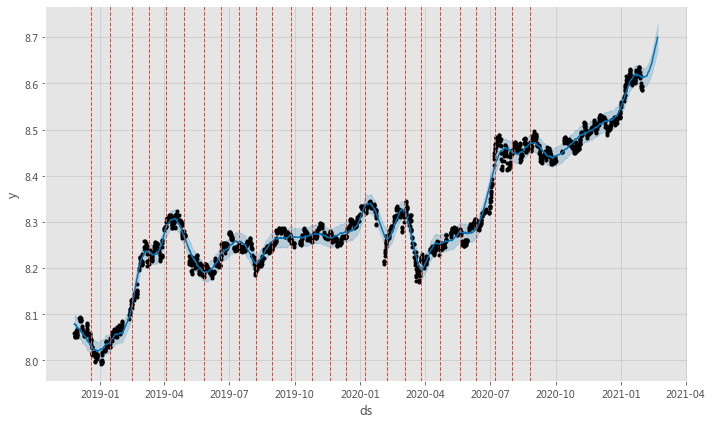

In [3]:
df = market_df.reset_index().rename(columns={'date':'ds', 'close':'y'})
df['y'] = np.log(df['y'])

# 构造模型并且训练数据
model = Prophet()
model.fit(df);

# 预测未来的periods个数据
future = model.make_future_dataframe(periods=22) #forecasting for 1 year from now.
forecast = model.predict(future)

plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['figure.figsize']=(20,10)
plt.style.use('ggplot')

figure = model.plot(forecast)
for changepoint in model.changepoints:
    plt.axvline(changepoint,ls='--', lw=1)

In [4]:
two_years = market_df.copy()
code = market_df.index.get_level_values(level=1)[0]
forecast['code'] = code
forecast = forecast.rename(columns={'ds':'date'}).set_index(['date', 'code'])
two_years = two_years.reindex(columns=[*two_years.columns,
                                        *['yhat', 'yhat_upper', 'yhat_lower']])
two_years.loc[:, ['yhat', 'yhat_upper', 'yhat_lower']] = forecast.loc[two_years.index,
                                                                      ['yhat', 'yhat_upper', 'yhat_lower']]
two_years['yhat']=np.exp(two_years.yhat)
two_years['yhat_upper']=np.exp(two_years.yhat_upper)
two_years['yhat_lower']=np.exp(two_years.yhat_lower)

<AxesSubplot:xlabel='datetime,code'>

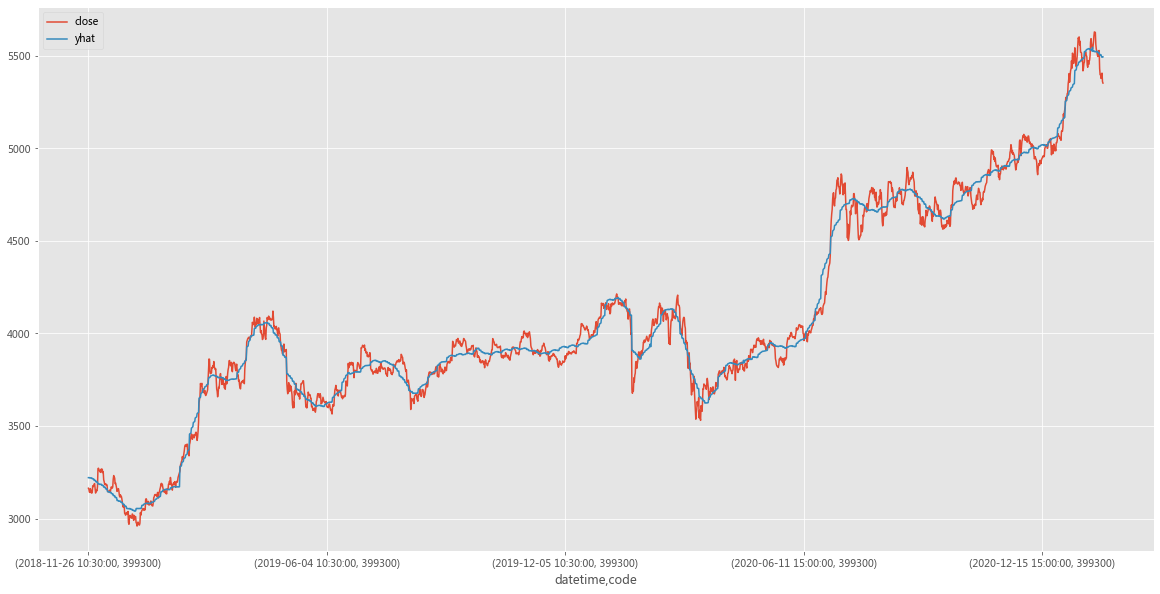

In [5]:
two_years[['close', 'yhat']].plot()

Text(0.5, 0, 'Date')

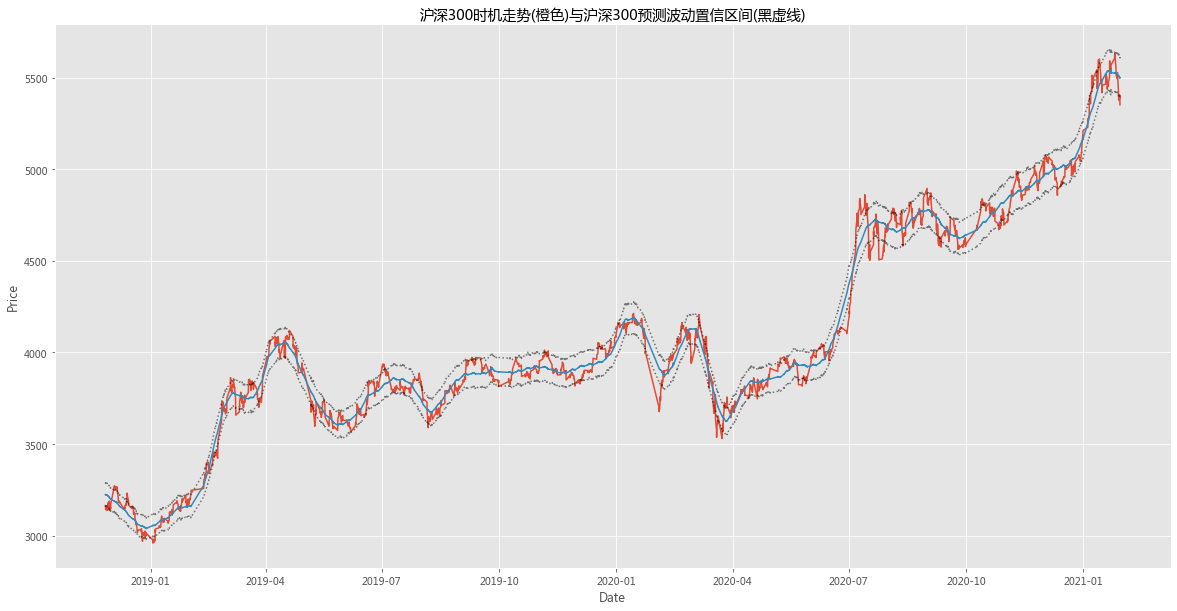

In [5]:
fig, ax1 = plt.subplots()
each_day = market_df.index.get_level_values(level=0)
ax1.plot(each_day, two_years.close)
ax1.plot(each_day, two_years.yhat)
ax1.plot(each_day, two_years.yhat_upper, color='black',  linestyle=':', alpha=0.5)
ax1.plot(each_day, two_years.yhat_lower, color='black',  linestyle=':', alpha=0.5)

ax1.set_title(u'沪深300时机走势(橙色)与沪深300预测波动置信区间(黑虚线)')
ax1.set_ylabel('Price')
ax1.set_xlabel('Date')

In [6]:
print(each_day[-1])

2021-01-29 15:00:00


In [7]:
model.changepoints

68     2018-12-19 10:30:00
136    2019-01-15 10:30:00
204    2019-02-14 10:30:00
272    2019-03-11 10:30:00
340    2019-04-03 10:30:00
408    2019-04-29 10:30:00
477    2019-05-27 11:30:00
545    2019-06-20 11:30:00
613    2019-07-15 11:30:00
681    2019-08-07 11:30:00
749    2019-08-30 11:30:00
817    2019-09-25 11:30:00
885    2019-10-25 11:30:00
953    2019-11-19 11:30:00
1021   2019-12-12 11:30:00
1089   2020-01-07 11:30:00
1157   2020-02-07 11:30:00
1225   2020-03-03 10:30:00
1294   2020-03-26 11:30:00
1362   2020-04-21 11:30:00
1430   2020-05-19 11:30:00
1498   2020-06-11 11:30:00
1566   2020-07-08 11:30:00
1634   2020-07-31 11:30:00
1702   2020-08-25 11:30:00
Name: ds, dtype: datetime64[ns]